# STEP 3 Audio Preparation and Model


In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
from tqdm.notebook import tqdm

In [2]:
#Global parameters
language_dic = {"es" : "Spanish" , "pt": "Portuguese", "it": "Italian", "fr": "French", "ca": "Catalan", "ro": "Romanian" }
analysis_window_length = 0.01  # 10 ms in seconds
language_mp3_path = "/language_detector/languages"

In [3]:
# number of repeats defined by minimum duration: ceil(10 seconds / min duration)
min_clip = 0.10115625
x_seconds = 5
num_reps = int(np.ceil(x_seconds / min_clip))
def repeat_audio_x_seconds(track, dur, num_repeats=10, fs=16000):
    num_samples_xs = int(fs * dur)
    track = np.concatenate([track]*num_repeats, axis=0)
    track = track[0:num_samples_xs]
    return track

In [8]:
def processing_audio(language_mp3_path, analysis_window_length, language_dic):
    """
    This function samples mp3 files, analyzes the dataset content, and builds a dictionary of features.
    """
    data = {"filename": [], "language": [], "mfccs": []}  # Initialize data dictionary here
   
    language_list = os.listdir(language_mp3_path)

    for language in language_list:
        language_path = os.path.join(language_mp3_path, language)

        if language not in language_dic:
            print(f"Skipping language {language} because it is not in language_dic")
            continue

        language_name = language_dic.get(language, "Unknown language!")

        clips_path = os.path.join(language_path, "clips")
        # Check if the clips directory exists
        if not os.path.isdir(clips_path):
            print(f"No 'clips' directory found in {language_path}")
            continue

        # get a list of all files in the folder
        mp3_list = os.listdir(clips_path)
        mp3_list = mp3_list[:15000]
       
        # looping through all mp3s in one language
        for mp3 in tqdm(mp3_list):
            # adding the filename as key
            data["filename"].append(mp3)
            # adding the label/language
            data["language"].append(language_name)
            # adding the clip
            audio_path = os.path.join(clips_path, mp3)
            audio_samples, fs = sf.read(audio_path)
            audio_samples = repeat_audio_x_seconds(audio_samples, x_seconds, num_repeats=num_reps, fs=fs)

            # Check if the length of repeated audio_samples is greater than n_fft
            n_fft_value = 2048
            if len(audio_samples) < n_fft_value:
                print(f"Skipping {mp3} because its length is less than n_fft even after repeating")
                continue

            y = audio_samples
            sr = fs
            hop_length = int(analysis_window_length * sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128, hop_length=hop_length, n_fft=n_fft_value)
            mfccs_scaled_features = np.mean(mfcc.T,axis=0)
            data["mfccs"].append(mfccs_scaled_features)

    return data


In [9]:
data = processing_audio(language_mp3_path, analysis_window_length, language_dic)

  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language ja because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Skipping language de because it is not in language_dic


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

In [10]:
# Printing shape to confirm the input to the model 
df = pd.DataFrame(data)
print(df.head())
df.mfccs[50].shape

                       filename language  \
0  common_voice_it_20088702.mp3  Italian   
1  common_voice_it_19551854.mp3  Italian   
2  common_voice_it_18743170.mp3  Italian   
3  common_voice_it_17435298.mp3  Italian   
4  common_voice_it_17643038.mp3  Italian   

                                               mfccs  
0  [-509.47060362868444, 141.85304069517989, -21....  
1  [-462.48287206723944, 123.8630827591188, 5.182...  
2  [-555.0763167749433, 118.43354473531377, 15.84...  
3  [-375.62301620292976, 110.90526244896759, -22....  
4  [-357.23725544830376, 163.21737813118395, -27....  


(128,)

In [11]:
# Generate a boolean mask where True indicates the mfccs is not of size 128
mask = [item.shape == (128, 220500) for item in df['mfccs']]

# Apply the mask to the dataframe
non_conforming_rows = df[mask]

# Print rows where the size of the mfccs array is not 128
print(non_conforming_rows)

                           filename language  \
10693  common_voice_it_21431109.mp3  Italian   

                                                   mfccs  
10693  [[-1131.370849898476, -1131.370849898476, -113...  


In [12]:
mask = [item.shape != (128, 220500) for item in df['mfccs']]

# Filter the dataframe using the mask
df = df[mask]

In [13]:
#Check-point to see if all data was correctly loaded
print(f'The number of files loaded is: {len(df["filename"])}, in {df["language"].nunique()} languages')

The number of files loaded is: 89999, in 6 languages


In [14]:
X = np.array(df['mfccs'].tolist())
y=np.array(df['language'].tolist())

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

2023-05-18 00:48:24.090916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 00:48:24.170578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 00:48:24.172434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 00:48:25.203594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                                    random_state=42,
                                                    train_size=0.8)

In [17]:
#Checking point
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(71999, 128) (18000, 128) (71999, 6) (18000, 6)


Model Creation

In [18]:
import tensorflow as tf
import visualkeras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [19]:
### No of classes
num_labels=y.shape[1]

In [20]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2023-05-18 00:48:45.519174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-18 00:48:45.519808: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               12900     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [22]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [23]:
## Training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
2220/2250 [============================>.] - ETA: 0s - loss: 2.6100 - accuracy: 0.1971
Epoch 1: val_loss improved from inf to 1.69304, saving model to saved_models/audio_classification.hdf5
2250/2250 [==============================] - 4s 1ms/step - loss: 2.5984 - accuracy: 0.1976 - val_loss: 1.6930 - val_accuracy: 0.2220
Epoch 2/100
2226/2250 [============================>.] - ETA: 0s - loss: 1.4895 - accuracy: 0.3288
Epoch 2: val_loss improved from 1.69304 to 0.96172, saving model to saved_models/audio_classification.hdf5
2250/2250 [==============================] - 3s 1ms/step - loss: 1.4852 - accuracy: 0.3305 - val_loss: 0.9617 - val_accuracy: 0.5241
Epoch 3/100
2211/2250 [============================>.] - ETA: 0s - loss: 1.0272 - accuracy: 0.5233
Epoch 3: val_loss improved from 0.96172 to 0.82129, saving model to saved_models/audio_classification.hdf5
2250/2250 [==============================] - 3s 1ms/step - loss: 1.0261 - accuracy: 0.5237 - val_loss: 0.8213 - val_accu

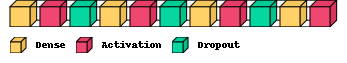

In [24]:
visualkeras.layered_view(model,legend=True, draw_volume=True)

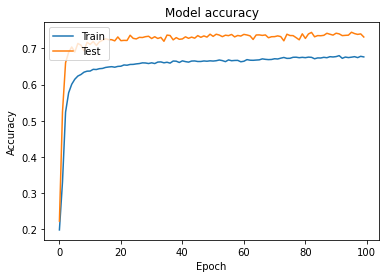

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

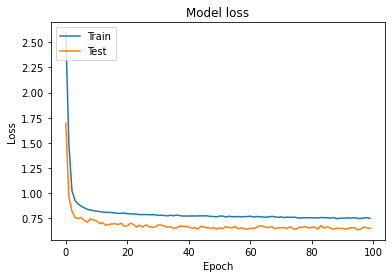

In [26]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [27]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7316111326217651


In [28]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

563/563 [==============================] - 0s 615us/step


In [29]:
from sklearn.metrics import classification_report
target_names = sorted(df.language.unique())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Catalan       0.78      0.84      0.81      2932
      French       0.56      0.87      0.68      3003
     Italian       0.75      0.46      0.57      2989
  Portuguese       0.86      0.81      0.83      2953
    Romanian       0.64      0.70      0.67      3062
     Spanish       0.98      0.71      0.83      3061

    accuracy                           0.73     18000
   macro avg       0.76      0.73      0.73     18000
weighted avg       0.76      0.73      0.73     18000



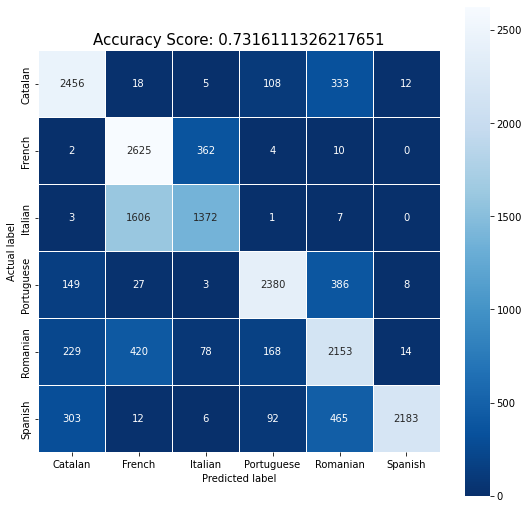

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plotting the results:
plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy[1])
plt.title(all_sample_title, size = 15);